# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

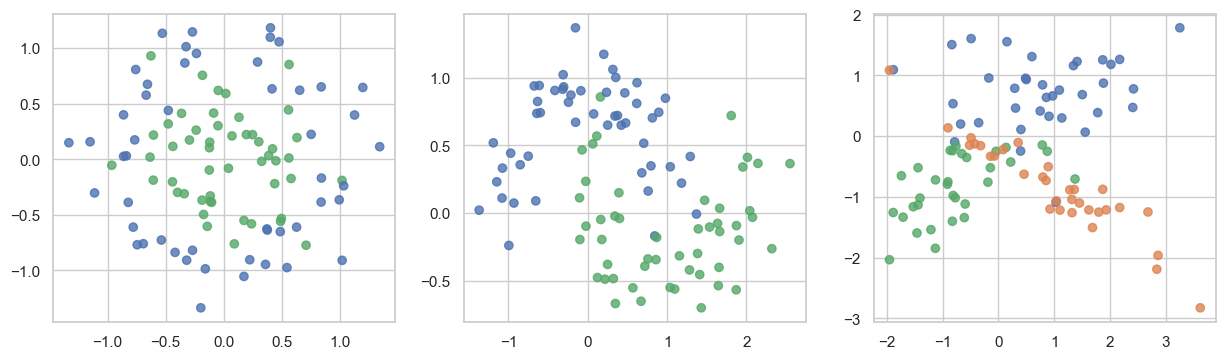

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

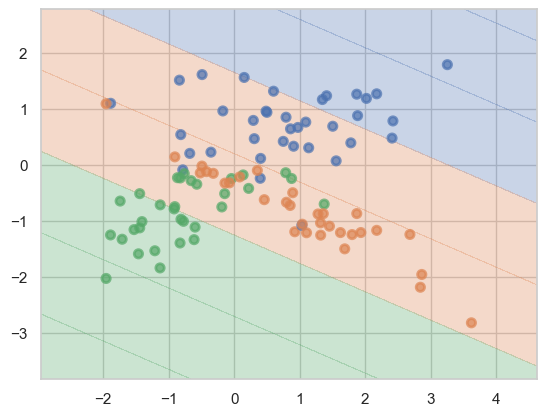

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

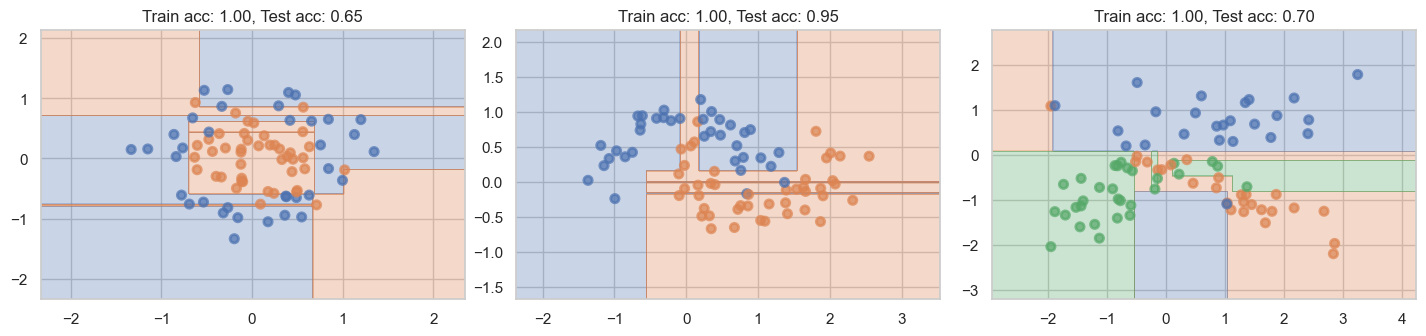

In [8]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 4))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    plt.subplot(1, 3, i + 1)
    plot_surface(clf, X_train, y_train)
    plt.title(f"Train acc: {accuracy_score(y_train, clf.predict(X_train)):.2f}, Test acc: {accuracy_score(y_test, clf.predict(X_test)):.2f}")

plt.show()

__Ответ:__

Решающие деревья продемонстрировали разную степень переобучения на трех датасетах. На круговых данных (make_circles) наблюдается сильное переобучение - дерево построило сложные границы с "зубцами", что привело к низкой тестовой accuracy (0.65) при идеальной обучающей. На данных "полумесяцах" (make_moons) переобучение минимально с высокой тестовой accuracy (0.95), а на многоклассовой линейно разделимой задаче - умеренное. Это показывает, что сложность переобучения зависит от структуры данных: хуже всего деревья справляются с концентрическими окружностями.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Dataset 1


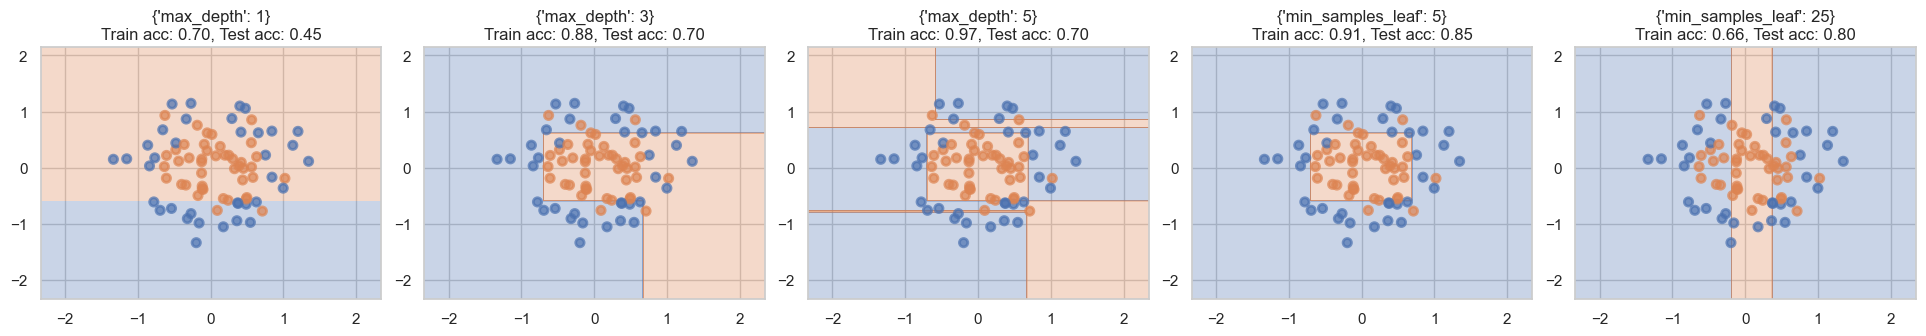

Dataset 2


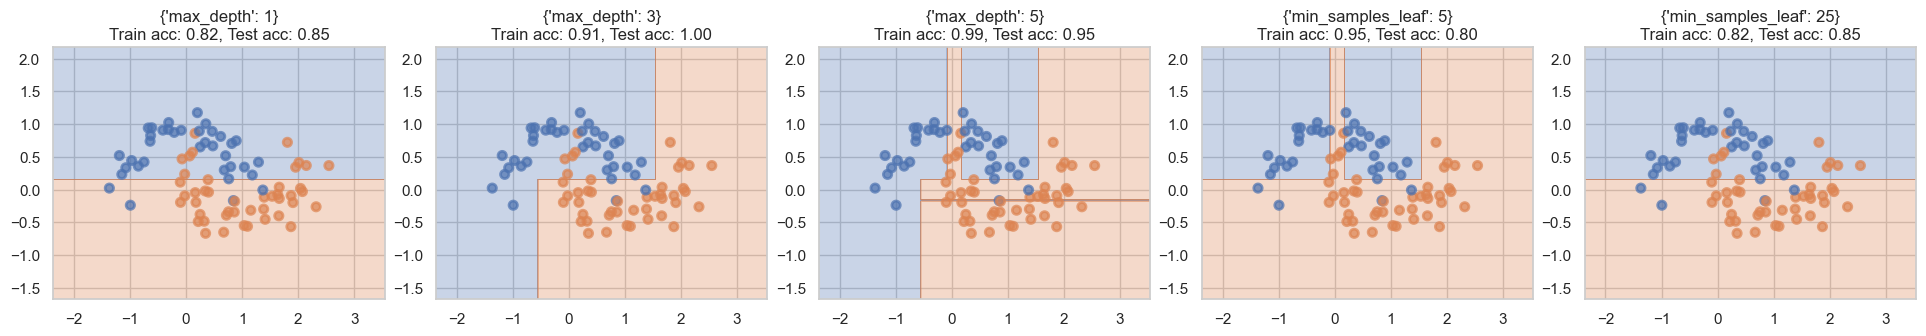

Dataset 3


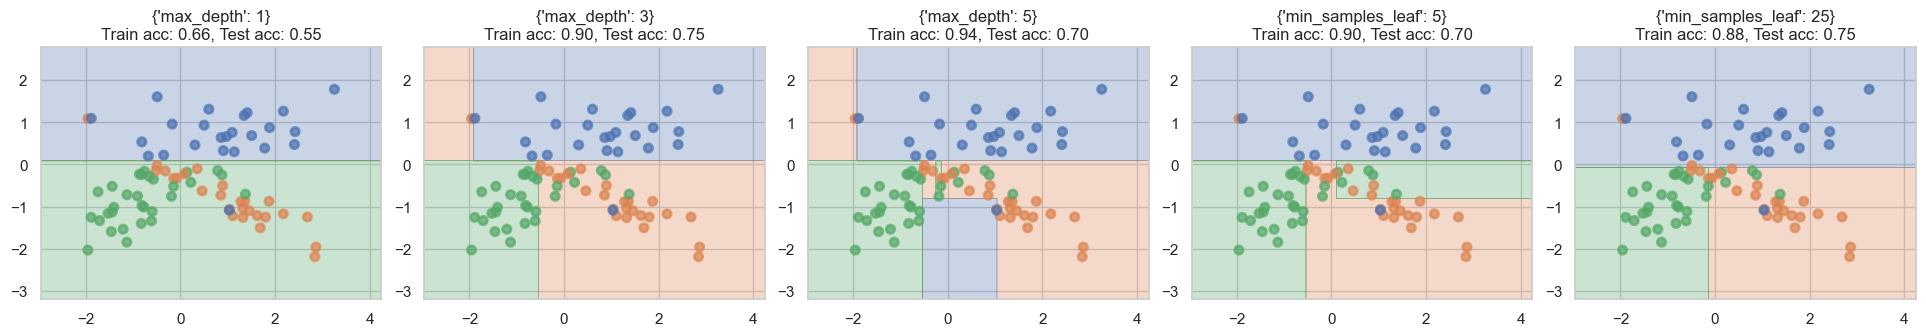

In [9]:
hypers = [
    {'max_depth': 1},
    {'max_depth': 3},
    {'max_depth': 5},
    {'min_samples_leaf': 5},
    {'min_samples_leaf': 25}
]

for i, (X, y) in enumerate(datasets):
    print(f"Dataset {i+1}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    plt.figure(figsize=(20, 4))
    for j, params in enumerate(hypers):
        clf = DecisionTreeClassifier(random_state=42, **params)
        clf.fit(X_train, y_train)
        
        plt.subplot(1, 5, j + 1)
        plot_surface(clf, X_train, y_train)
        train_acc = accuracy_score(y_train, clf.predict(X_train))
        test_acc = accuracy_score(y_test, clf.predict(X_test))
        plt.title(f"{params}\nTrain acc: {train_acc:.2f}, Test acc: {test_acc:.2f}")
    plt.show()

__Ответ:__

max_depth: при малой глубине (1) модель недообучается (линейная разделяющая поверхность). С увеличением глубины границы становятся сложнее, точность на трейне растет, но после определенного момента на тесте может падать (так случилось на датасете 2 и 3).

min_samples_leaf: Увеличение этого параметра сглаживает границы, делая модель более устойчивой (регуляризация). Мелкие островки и зубцы исчезают.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

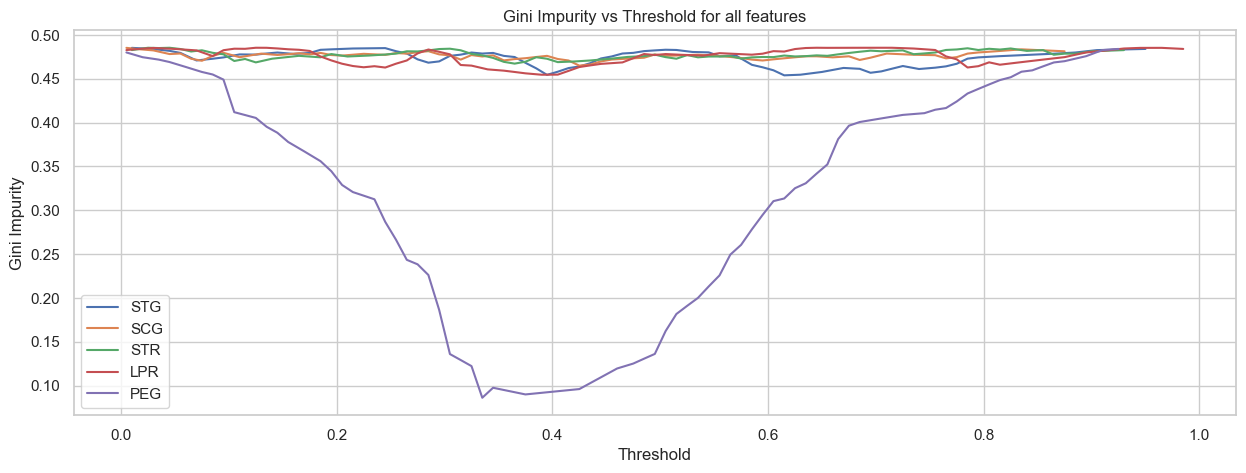

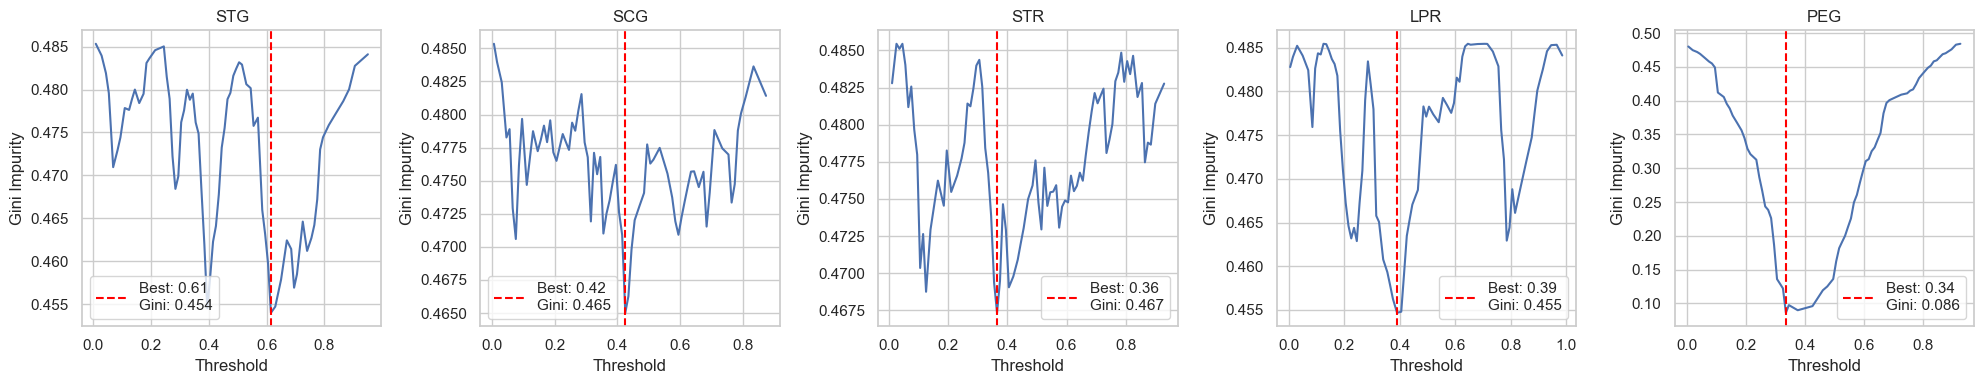

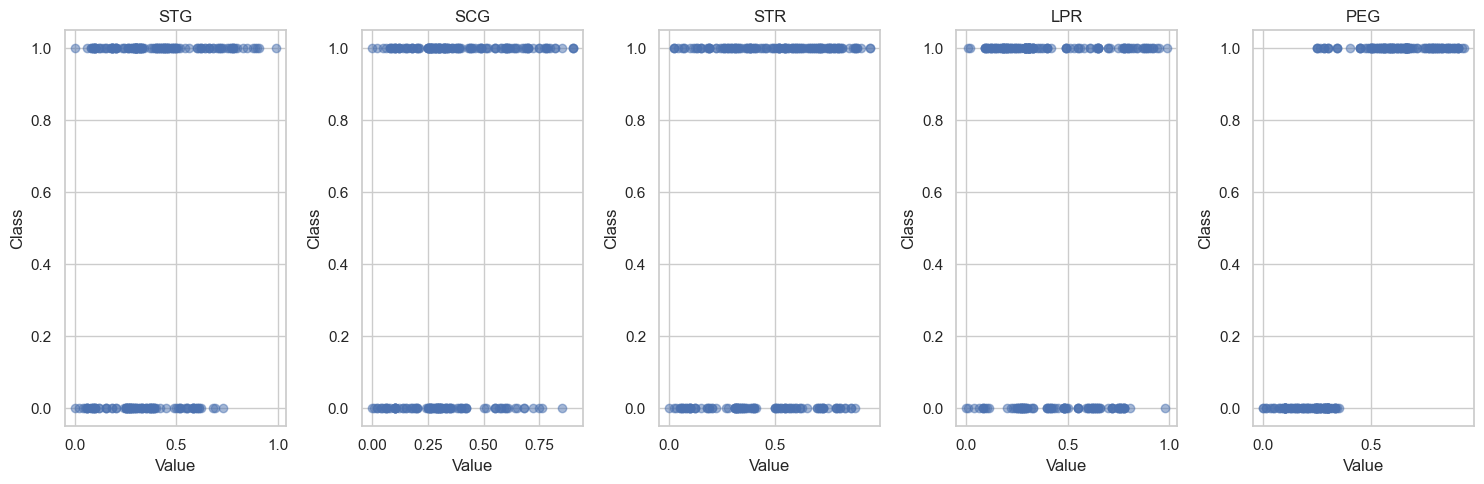

In [10]:
from hw2code import find_best_split

df_students = pd.read_csv('datasets/students.csv')

y_students = df_students['UNS'].values
X_students = df_students.drop('UNS', axis=1).values
feature_names = df_students.columns[:-1]

plt.figure(figsize=(15, 5))
for i, feature_name in enumerate(feature_names):
    thresholds, ginis, _, _ = find_best_split(X_students[:, i], y_students)
    plt.plot(thresholds, ginis, label=feature_name)

plt.xlabel("Threshold")
plt.ylabel("Gini Impurity")
plt.legend()
plt.title("Gini Impurity vs Threshold for all features")
plt.show()

plt.figure(figsize=(20, 4))
for i, feature_name in enumerate(feature_names):
    plt.subplot(1, 5, i+1)
    thresholds, ginis, best_threshold, best_gini = find_best_split(X_students[:, i], y_students)
    plt.plot(thresholds, ginis)
    if best_threshold is not None:
        plt.axvline(x=best_threshold, color='red', linestyle='--', 
                   label=f'Best: {best_threshold:.2f}\nGini: {best_gini:.3f}')
    plt.xlabel("Threshold")
    plt.ylabel("Gini Impurity")
    plt.title(f"{feature_name}")
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, feature_name in enumerate(feature_names):
    plt.subplot(1, 5, i+1)
    plt.scatter(X_students[:, i], y_students, alpha=0.5)
    plt.title(feature_name)
    plt.xlabel("Value")
    plt.ylabel("Class")
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Нужно выбирать признак, который дает минимальное значение критерия Джини (самую глубокую яму на графике), в данном случае это PEG.

Этот результат согласуется с scatter-графиками. Мы видим для признака PEG четкое разделение на классы по величине значения (низкое -> класс 0, высокое -> класс 1), я для остальных признаков точки перемешаны.

Для хороших признаков кривая имеет глубокий и четкий минимум. Это означает, существует порог, который четко делит выборку.
Для плохого признака кривая плоская или хаотичная, значения Джини остаются высокими (близко к 0.5) по всему диапазону.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Ответ__:
Ошибки указаны как комментарии в коде

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [11]:
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree

df_mush = pd.read_csv('datasets/agaricus-lepiota.data', header=None)

label_encoders = {}
for col in df_mush.columns:
    le = LabelEncoder()
    df_mush[col] = le.fit_transform(df_mush[col])
    label_encoders[col] = le

y_mush = df_mush[0].values
X_mush = df_mush.drop(0, axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X_mush, y_mush, test_size=0.5, random_state=42)

types = ["categorical"] * X_train.shape[1]

tree = DecisionTree(feature_types=types)
tree.fit(X_train, y_train)

preds = tree.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy on Mushrooms: {acc}")

Accuracy on Mushrooms: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

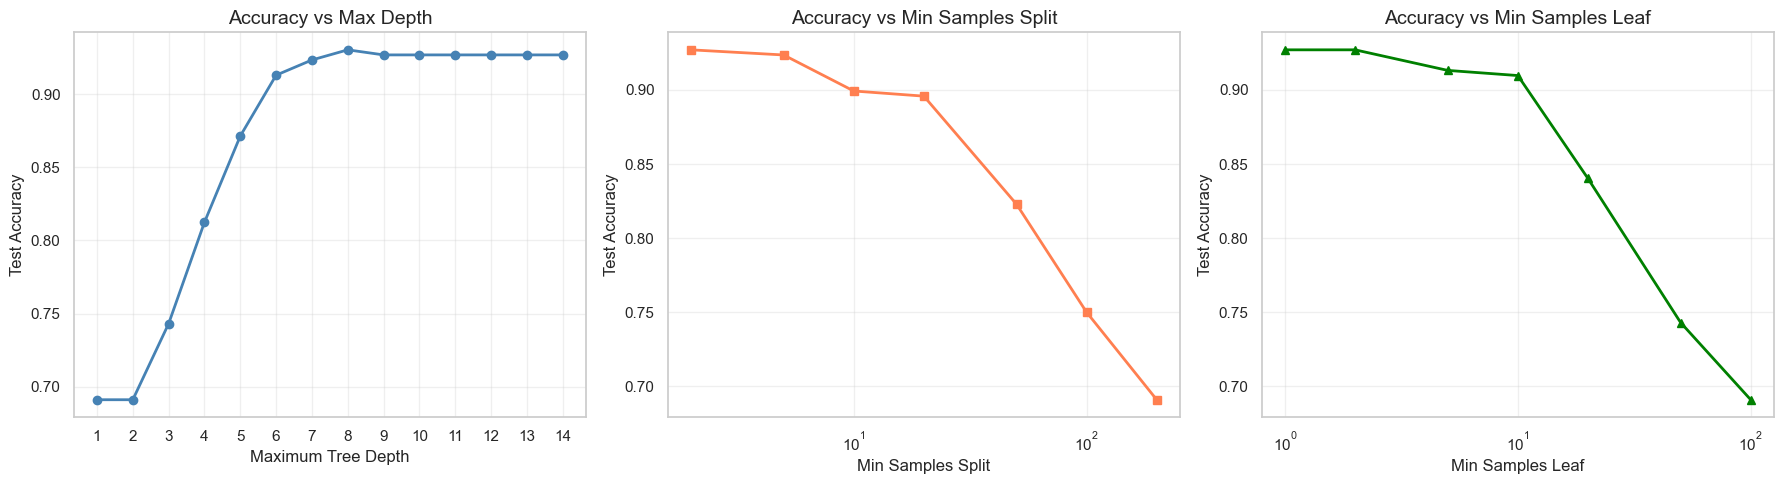

Optimal max_depth: 8 (accuracy: 0.931)
Optimal min_samples_split: 2 (accuracy: 0.927)
Optimal min_samples_leaf: 1 (accuracy: 0.927)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

ttt_df = pd.read_csv('datasets/tic-tac-toe-endgame.csv')
label_enc = LabelEncoder()

encoded_df = ttt_df.apply(label_enc.fit_transform)

X_data = encoded_df.drop(columns=['V10']).values
y_data = encoded_df['V10'].values
feature_types_list = ['categorical'] * X_data.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    test_size=0.3, 
    random_state=42
)

depth_values = list(range(1, 15))
depth_scores = []

for depth in depth_values:
    tree_model = DecisionTree(
        feature_types=feature_types_list, 
        max_depth=depth
    )
    tree_model.fit(X_train, y_train)
    predictions = tree_model.predict(X_test)
    depth_scores.append(accuracy_score(y_test, predictions))

split_values = [2, 5, 10, 20, 50, 100, 200]
split_scores = []

for min_split in split_values:
    tree_model = DecisionTree(
        feature_types=feature_types_list,
        min_samples_split=min_split
    )
    tree_model.fit(X_train, y_train)
    predictions = tree_model.predict(X_test)
    split_scores.append(accuracy_score(y_test, predictions))

leaf_values = [1, 2, 5, 10, 20, 50, 100]
leaf_scores = []

for min_leaf in leaf_values:
    tree_model = DecisionTree(
        feature_types=feature_types_list,
        min_samples_leaf=min_leaf
    )
    tree_model.fit(X_train, y_train)
    predictions = tree_model.predict(X_test)
    leaf_scores.append(accuracy_score(y_test, predictions))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(depth_values, depth_scores, 'o-', linewidth=2, markersize=6, color='steelblue')
axes[0].set_xlabel('Maximum Tree Depth', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Max Depth', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(depth_values)

axes[1].plot(split_values, split_scores, 's-', linewidth=2, markersize=6, color='coral')
axes[1].set_xlabel('Min Samples Split', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Accuracy vs Min Samples Split', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

axes[2].plot(leaf_values, leaf_scores, '^-', linewidth=2, markersize=6, color='green')
axes[2].set_xlabel('Min Samples Leaf', fontsize=12)
axes[2].set_ylabel('Test Accuracy', fontsize=12)
axes[2].set_title('Accuracy vs Min Samples Leaf', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

best_depth_idx = depth_scores.index(max(depth_scores))
best_split_idx = split_scores.index(max(split_scores))
best_leaf_idx = leaf_scores.index(max(leaf_scores))

print(f"Optimal max_depth: {depth_values[best_depth_idx]} (accuracy: {depth_scores[best_depth_idx]:.3f})")
print(f"Optimal min_samples_split: {split_values[best_split_idx]} (accuracy: {split_scores[best_split_idx]:.3f})")
print(f"Optimal min_samples_leaf: {leaf_values[best_leaf_idx]} (accuracy: {leaf_scores[best_leaf_idx]:.3f})")

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from hw2code import DecisionTree

# Кастомную cross_val_score пришлось написать из-за несовпадения нашего DecisionTree со sklearn
def custom_cross_val_score(estimator, X, y, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        if hasattr(estimator, '_fit_node'):
            model = DecisionTree(
                feature_types=estimator._feature_types,
                max_depth=estimator._max_depth,
                min_samples_split=estimator._min_samples_split,
                min_samples_leaf=estimator._min_samples_leaf
            )
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
        else:
            model = estimator.__class__(**estimator.get_params())
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            
        scores.append(accuracy_score(y_test, predictions))
    
    return np.array(scores)

datasets_info = [
    {
        'name': 'mushrooms',
        'url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
        'target_col': 0
    },
    {
        'name': 'tic-tac-toe', 
        'file': 'datasets/tic-tac-toe-endgame.csv',
        'target_col': -1
    },
    {
        'name': 'cars',
        'url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
        'target_col': -1
    },
    {
        'name': 'nursery',
        'url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', 
        'target_col': -1
    }
]

results = []

for dataset_info in datasets_info:
    print(f"Processing {dataset_info['name']}...")
    
    if 'file' in dataset_info:
        df = pd.read_csv(dataset_info['file'])
    else:
        df = pd.read_csv(dataset_info['url'], header=None)
    
    if dataset_info['target_col'] == 0:
        y = df.iloc[:, 0].values
        X = df.iloc[:, 1:].values
    else:
        y = df.iloc[:, -1].values
        X = df.iloc[:, :-1].values
    
    if dataset_info['name'] == 'cars':
        y = np.where((y == 'unacc') | (y == 'acc'), 0, 1)
    elif dataset_info['name'] == 'nursery':
        y = np.where((y == 'not_recom') | (y == 'recommend'), 0, 1)
    else:
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
    
    X_encoded = np.zeros_like(X, dtype=float)
    for i in range(X.shape[1]):
        le = LabelEncoder()
        X_encoded[:, i] = le.fit_transform(X[:, i])
    
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_onehot = encoder.fit_transform(X)
    
    models = {
        'Our DT (real)': DecisionTree(feature_types=['real'] * X_encoded.shape[1]),
        'Our DT (categorical)': DecisionTree(feature_types=['categorical'] * X_encoded.shape[1]),
        'Our DT (real + OHE)': DecisionTree(feature_types=['real'] * X_onehot.shape[1]),
        'Sklearn DT': DecisionTreeClassifier(random_state=42)
    }
    
    datasets_model = {
        'Our DT (real)': X_encoded,
        'Our DT (categorical)': X_encoded, 
        'Our DT (real + OHE)': X_onehot,
        'Sklearn DT': X_encoded
    }
    
    dataset_results = {'Dataset': dataset_info['name']}
    for model_name, model in models.items():
        X_data = datasets_model[model_name]
        
        if 'Our DT' in model_name:
            scores = custom_cross_val_score(model, X_data, y, cv=10)
        else:
            from sklearn.model_selection import cross_val_score
            scores = cross_val_score(model, X_data, y, cv=10, scoring='accuracy')
            
        dataset_results[model_name] = np.mean(scores)
        print(f"  {model_name}: {dataset_results[model_name]:.4f}")
    
    results.append(dataset_results)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Dataset')
print("\nFinal Results:")
print(results_df)

results_df.to_csv('decision_tree_comparison.csv')

Processing mushrooms...
  Our DT (real): 1.0000
  Our DT (categorical): 1.0000
  Our DT (real + OHE): 1.0000
  Sklearn DT: 0.9604
Processing tic-tac-toe...
  Our DT (real): 0.8789
  Our DT (categorical): 0.9447
  Our DT (real + OHE): 0.9447
  Sklearn DT: 0.7717
Processing cars...
  Our DT (real): 0.9902
  Our DT (categorical): 0.9873
  Our DT (real + OHE): 0.9879
  Sklearn DT: 0.9427
Processing nursery...
  Our DT (real): 0.9998
  Our DT (categorical): 0.9998
  Our DT (real + OHE): 0.9998
  Sklearn DT: 0.9997

Final Results:
             Our DT (real)  Our DT (categorical)  Our DT (real + OHE)  \
Dataset                                                                 
mushrooms         1.000000              1.000000             1.000000   
tic-tac-toe       0.878914              0.944715             0.944715   
cars              0.990163              0.987273             0.987851   
nursery           0.999769              0.999769             0.999769   

             Sklearn DT  
Data

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Mushrooms: Все наши реализации показывают 100% точность против 96% у sklearn.

Tic-Tac-Toe: Категориальные признаки значительно лучше числовых (94.5% vs 87.9%). One-Hot Encoding повторяет результат категориальных признаков. Наш алгоритм существенно превосходит sklearn (94.5% vs 77.2%).

Cars: Все методы показывают высокую точность (~99%), наш алгоритм немного лучше sklearn.

Nursery: Все методы демонстрируют почти идеальную точность (~100%), различия минимальны.

Признаки: на Mushrooms и Tic-Tac-Toe (категориальные признаки) наш Custom(Cat) и Custom(OHE) работают значительно лучше, чем Sklearn или Custom(Real).
На Cars и Nursery (где признаки имеют естественный порядок, например, "low", "med", "high") разрыв сокращается, так как трактовка их как вещественных чисел (0, 1, 2) через LabelEncoder не так сильно нарушает логику данных.

Компонента случайности присутствует: это shuffle=True в KFold и random_state (перемешивание данных и начальное значение для генератора случайных чисел). Можно было бы добавить random_state в наш DecisionTree для детерминированности, также реализовать поддержку кросс-валидации внутри подбора гиперпараметров.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

＼(￣▽￣)／